In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import os
import numpy as np
import statsmodels.api as sm

import sys; sys.path.insert(0, '../')
from solvel0 import solvel0
from sklearn.linear_model import LinearRegression

from rdata import read_rds

In [2]:
R_path = "../Cache/"
X_pre = np.load(os.path.join(R_path, 'X_pre_kdv_noise50.npy'))
y_pre = np.load(os.path.join(R_path, 'y_pre_kdv_noise50.npy'))

In [3]:
bestsubset = solvel0(X_pre, y_pre, max_complexity=2, miosr=True)[-1]

select = np.zeros(X_pre.shape[-1]).astype(np.bool_)
select[list(bestsubset)] = True

X_sel = X_pre[:, select]
X_not_select = X_pre[:, ~select]

lr = LinearRegression(fit_intercept=False)
lr.fit(X_sel, y_pre)
y_est = lr.predict(X_sel)

X_test = np.hstack([y_est, X_not_select])

  0%|                                                                                                  | 0/2 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-04


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


In [4]:
active_set = []
pvalues = []
nfeats = X_test.shape[-1]
while len(active_set) < nfeats:
    possible_indices = [i for i in range(X_test.shape[-1]) if i not in active_set]
    r2s = []
    fits = []
    for i in possible_indices:
        fit = sm.OLS(y_pre, X_test[:, active_set+[i]]).fit()
        fits.append(fit)
        r2s.append(fit.rsquared)
    active_set.append(possible_indices[np.argmax(r2s)])
    # print(active_set)
    pvalues.append(fits[np.argmax(r2s)].pvalues[-1])
assert len(active_set) == nfeats

In [5]:
fsInf = read_rds("../R/fsInf_kdv_noise50.rds")
adjusted_pvalues = fsInf.get("pv")

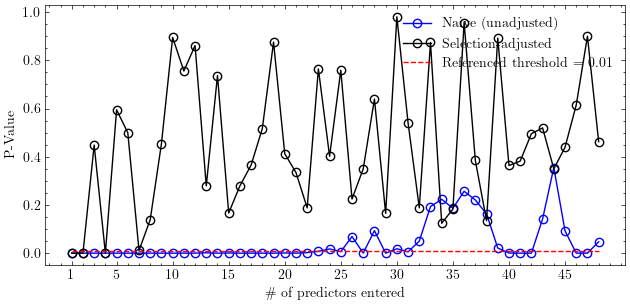

In [6]:
with plt.style.context("science"):
    plt.figure(figsize=(6.5, 3.25))
    plt.plot([i for i in range(1, len(active_set)+1)], pvalues, '-o', c='blue', markerfacecolor='none', label='Naive (unadjusted)')
    plt.plot([i for i in range(1, len(active_set)+1)], adjusted_pvalues, '-o', c='black', markerfacecolor='none', label='Selection-adjusted')
    plt.hlines(xmin=1, xmax=len(active_set), y=0.01, colors='red', linestyles='dashed', label="Referenced threshold $= 0.01$")
    plt.ylabel("P-Value")
    plt.xlabel("\# of predictors entered")
    plt.xticks([1]+[i for i in range(1, len(active_set)+1) if i%5 == 0])
    plt.legend()
    plt.tight_layout()
    plt.savefig("../Figures/pv_kdv_noise50.pdf")
    plt.show()

In [7]:
from selective_inference import forward_stop_rule

In [8]:
stop_step1, false_discovery_rates = forward_stop_rule(adjusted_pvalues, 0.01)
stop_step2, false_discovery_rates = forward_stop_rule(adjusted_pvalues, 0.05)

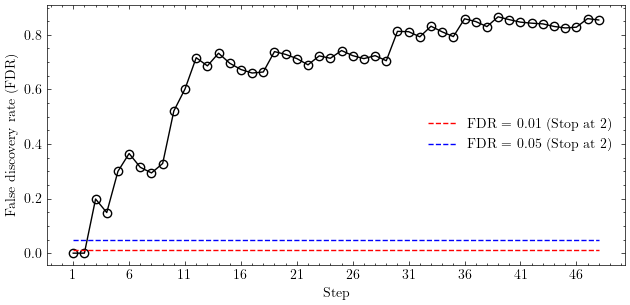

In [9]:
with plt.style.context("science"):
    plt.figure(figsize=(6.5, 3.25))
    plt.plot([_ for _ in range(1, len(false_discovery_rates)+1)], false_discovery_rates, '-o', c='black', markerfacecolor='None')
    plt.hlines(0.01, 1, len(false_discovery_rates), linestyles='--', color='red', label=f'FDR = 0.01 (Stop at {stop_step1+1})')
    plt.hlines(0.05, 1, len(false_discovery_rates), linestyles='--', color='blue', label=f'FDR = 0.05 (Stop at {stop_step2+1})')
    plt.ylabel("False discovery rate (FDR)")
    plt.xlabel("Step")
    plt.xticks([_ for _ in range(1, len(false_discovery_rates)+1) if (_-1)%5==0])
    plt.legend(loc='center right')
    plt.show()